# QN resolved spectra.
Plot the points in the spectrum resolved with some information on their quantum numbers.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import copy


import sys
sys.path.append('../python_data/')
from ed_result_wrapper import EDResult

data_dir = "../python_data/full_production_data/"


def _select_close(cond, df, atol=1e-8):
    """ Selects rows of df if they are close to all conditions in the 
        cond dictionary.
    
        Use with caution!
    
        Note:
         -  The numerical tolerance for closenes is toggled via atol. 
            The standard is 1e-8 (in fact, by numpy) but this could 
            lead to problems when comparing very small numbers.
            
    """
    m = sub.apply(
        lambda r: all([np.all(np.isclose(r[o], v, atol=atol)) for o, v in cond.items()])
    , axis=1)
    return df[m]



def insert_gap(dataframes, winding=True):
    """ Takes a list of dataframes, as obtained from the result wrapper, 
        and returns a dataframe which has information on the corresponding 
        ground state at the given value of lambda.
        
        Adds the following columns:
            - gs_energy
            - gs_winding
            - gap (distance to the ground state at the given lambda)
    
        Notes:
         - This works only if the same values of lambda are present in all datasets.
         - Technically, this could be extended with interpolation, however, I wouldn't to it.
    """
    
    # First, merge all dataframes into a big one.
    # (needs to be a copy for safety)
    alldf = copy(dataframes[0])
    for df in dataframes[1:]:
        alldf = alldf.append(df)
        
    # Find all unique lambdas and make a gs dataframe.
    lams = sorted(list(set(alldf['lambda'])))
    gs = np.zeros(shape=(len(lams),3))
    gs[:,0] = lams
    
    # Loop through all lambdas.
    # For every lambda:
    #  - select appropriate rows
    #  - find the lowest energy value and store as gs_energy
    #  - find the winding of the lowest energy value and store as gs_winding
    for k, lam in enumerate(lams):
        sub = alldf[alldf['lambda']==lam]
        gs[k,1] = np.min(sub['spectrum'])
        if winding:
            gs[k,2] = sub.iloc[sub['spectrum'].argmin()]['winding_sector'][-1]
    
    # Finally make this a DataFrame, needed to efficiently add it to the big DataFrame.
    gsdf = pd.DataFrame(gs, columns=['lambda', 'gs_energy', 'gs_winding'])
    
    # The merge updates all entries that have a specific lambda value with the entries that
    # are in the gsdf for this lambda - this also creates duplicates.
    newdf = pd.merge(gsdf, alldf, on='lambda')
    
    # Now we can easily compute the gap.
    newdf['gap'] = newdf['spectrum'] - newdf['gs_energy']
    return newdf

Generally, reading of the results with the EDResult wrapper can be done on the fly. However, the 2x2x2 data was obtained with full diagonalization which implies many entries to convert -> this adds some overhead time. It's convenient to pre-load them for later use. For the 2x2x4 we still do this on the fly.

*Update: this is only for full diagonalization data, meanwhile we have the sparser data as well - agrees nicely.*

#### Style for datasets.
Here we set, centrally, the style for all datasets - so that it is consistent over all plots.

In [3]:
# Highlight some.
sets = [
    ({'parity':  1, 'winding_sector': (0,0,0)}, {"color":"#4F5D75", 'marker':'^', 'label':'$W=[000],\ P^+$', 's':25}),        
    ({'parity': -1, 'winding_sector': (0,0,0)}, {"color":"#68C5DB", 'marker':'v', 'label':'$W=[000],\ P^-$', 's':20}),

    ({'parity':  1, 'winding_sector': (0,0,1)}, {"color":"#BC3908", 'marker':'^', 'label':'$W=[001],\ P^+$', 's':20}),        
    ({'parity': -1, 'winding_sector': (0,0,1)}, {"color":"#F6AA1C", 'marker':'v', 'label':'$W=[001],\ P^-$', 's':20}),

    ({'parity':  1, 'winding_sector': (1,0,0)}, {"color":"#74A57F", 'marker':'^', 'label':'$W=[100],\ P^+$', 's':20}),        
    ({'parity': -1, 'winding_sector': (1,0,0)}, {"color":"#9ECE9A", 'marker':'v', 'label':'$W=[100],\ P^-$', 's':20}),
    
    ({'parity':  1, 'winding_sector': (0,0,2)}, {"color":"#7E1F86", 'marker':'^', 'label':'$W=[002],\ P^+$', 's':20}),        
    ({'parity': -1, 'winding_sector': (0,0,2)}, {"color":"#A14DA0", 'marker':'v', 'label':'$W=[002],\ P^-$', 's':20})
]

ED results for datafile '/home/lukas/_TEMP_fqlm/more_winding/clean_data//results_fermions_wx_4-wy_4-wz_2_2x2x4.hdf5'
ED results for datafile '/home/lukas/_TEMP_fqlm/more_winding/clean_data//results_fermions_wx_5-wy_4-wz_2_2x2x4.hdf5'
ED results for datafile '/home/lukas/_TEMP_fqlm/more_winding/clean_data//results_fermions_wx_4-wy_4-wz_3_2x2x4.hdf5'
ED results for datafile '/home/lukas/_TEMP_fqlm/more_winding/clean_data//results_fermions_wx_6-wy_4-wz_2_2x2x4.hdf5'
ED results for datafile '/home/lukas/_TEMP_fqlm/more_winding/clean_data//results_fermions_wx_5-wy_5-wz_2_2x2x4.hdf5'
ED results for datafile '/home/lukas/_TEMP_fqlm/more_winding/clean_data//results_fermions_wx_5-wy_4-wz_3_2x2x4.hdf5'
ED results for datafile '/home/lukas/_TEMP_fqlm/more_winding/clean_data//results_fermions_wx_4-wy_4-wz_4_2x2x4.hdf5'
ED results for datafile '/home/lukas/_TEMP_fqlm/more_winding/clean_data//results_fermions_wx_6-wy_4-wz_3_2x2x4.hdf5'
ED results for datafile '/home/lukas/_TEMP_fqlm/more_winding/cle

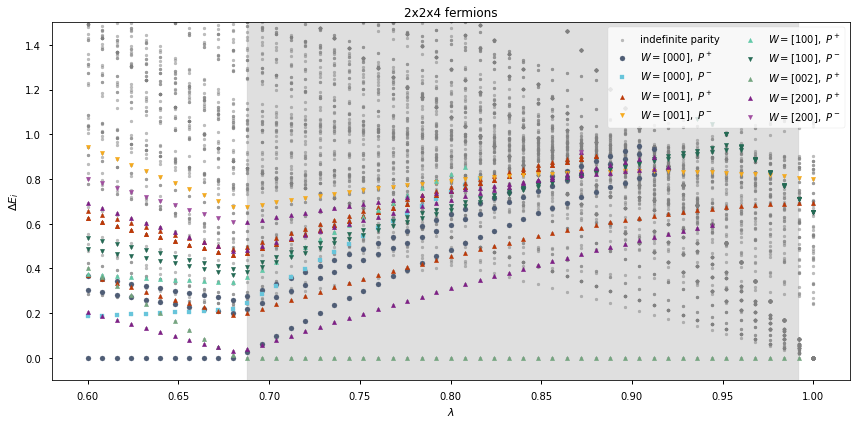

In [44]:
# Choose the dataset.
param = {
    'L' : [2,2,4],
    'gauge_particles' : 'fermions',
}

data_dir = '/home/lukas/_TEMP_fqlm/more_winding/clean_data/'
results = [
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[0,0,0]}, data_dir),
    
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[1,0,0]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[0,0,1]}, data_dir),
    
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[2,0,0]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[1,1,0]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[1,0,1]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[0,0,2]}, data_dir),
    
#     EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[3,0,0]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[2,0,1]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[2,1,0]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[1,1,1]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[1,0,2]}, data_dir),
    
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,0,0]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[3,0,1]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[3,1,0]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[2,0,2]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[2,1,1]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[2,2,0]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[1,1,2]}, data_dir),
    
    
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,1,0]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,0,1]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[3,2,0]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[3,1,1]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[3,0,2]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[2,2,1]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[2,1,2]}, data_dir),
    
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,2,0]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,1,1]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,0,2]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[3,3,0]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[3,2,1]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[3,1,2]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[2,2,2]}, data_dir),
    
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,3,0]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,2,1]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,1,2]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[3,3,1]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[3,2,2]}, data_dir),
    
    
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,4,0]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,3,1]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,2,2]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[3,3,2]}, data_dir),
    
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,4,1]}, data_dir),
    EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,3,2]}, data_dir),
    
#     EDResult({'L':[2,2,4], 'gauge_particles':'fermions', 'winding_sector':[4,4,2]}, data_dir),
]
    
# Combine and compute the gap.
df = insert_gap([r.get_eigenvalues() for r in results])

# Select only the lowest states.
n_states = 5
sub = df[
    (df['N']<n_states) &
    (df['lambda']<=1.0) &
    (df['lambda']>=-3.0)
]


dependency = 'lambda'
observable = 'gap'
with plt.style.context('seaborn-notebook'):
    fig, bx = plt.subplots()
    fig.set_size_inches(12, 6)
    
    # All points.
    bx.scatter(sub[dependency], sub[observable], marker='.', color='gray', alpha=0.5, zorder=1, s=35, label='indefinite parity')
    
#     Find GS of different winding.
    wind = sub[sub['gs_winding']==2]
    ll, lu = min(wind['lambda']), max(wind['lambda'])
    bx.fill_between([ll, lu], -5, 100, zorder=0, alpha=0.25, color='gray')
    
    sets = [
    ({'parity':  1, 'winding_sector': (0,0,0)}, {"color":"#4F5D75", 'marker':'o', 'label':'$W=[000],\ P^+$', 's':25}),        
    ({'parity': -1, 'winding_sector': (0,0,0)}, {"color":"#68C5DB", 'marker':'s', 'label':'$W=[000],\ P^-$', 's':20}),

    ({'parity':  1, 'winding_sector': (0,0,1)}, {"color":"#BC3908", 'marker':'^', 'label':'$W=[001],\ P^+$', 's':20}),        
    ({'parity': -1, 'winding_sector': (0,0,1)}, {"color":"#F6AA1C", 'marker':'v', 'label':'$W=[001],\ P^-$', 's':20}),
        
    ({'parity':  1, 'winding_sector': (1,0,0)}, {"color":"#61C9A8", 'marker':'^', 'label':'$W=[100],\ P^+$', 's':20}),        
    ({'parity': -1, 'winding_sector': (1,0,0)}, {"color":"#246A54", 'marker':'v', 'label':'$W=[100],\ P^-$', 's':20}),

    ({'parity':  1, 'winding_sector': (0,0,2)}, {"color":"#74A57F", 'marker':'^', 'label':'$W=[002],\ P^+$', 's':20}),        
    ({'parity': -1, 'winding_sector': (0,0,2)}, {"color":"#9ECE9A", 'marker':'v', 'label':'$W=[002],\ P^-$', 's':20}),
    
    ({'parity':  1, 'winding_sector': (2,0,0)}, {"color":"#7E1F86", 'marker':'^', 'label':'$W=[200],\ P^+$', 's':20}),        
    ({'parity': -1, 'winding_sector': (2,0,0)}, {"color":"#A14DA0", 'marker':'v', 'label':'$W=[200],\ P^-$', 's':20})
]
    
    for cond, style in sets:
        red = _select_close(cond, sub)
        if len(red):
            bx.scatter(red[dependency], red[observable], **style)
        
    # ---
        
    bx.set_xlabel('$\\lambda$')
    bx.set_ylabel('$\\Delta E_i$')
    bx.set_ylim(-0.1, 1.5)
    
#     bx.set_ylim(-3, 1)
#     bx.set_xlim(0.65, 1)

    bx.legend(loc='upper right', ncol=2)
    bx.set_title('{:d}x{:d}x{:d} {:s}'.format(*param['L'], param['gauge_particles']))
    
#     bx.set_yscale('log')
    
    fig.tight_layout()
#     fig.savefig('zoomed_spectrum_{:s}_{:d}x{:d}x{:d}.pdf'.format(param['gauge_particles'], *param['L']))